In [28]:
import rasterio as rio
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rasterstats import zonal_stats
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

raster_dir = '/home/mcoving/Dropbox/sync/projects/Dolines/comparison_data/chelsa_v2/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/'

raster_key = pd.read_excel('raster-data-key.xlsx', index_col=0)

p_karst_df = gpd.read_file('carb_huc_dems/processed_hucs.shp')
# Raster data is in EPSG:4326
p_karst_df_4326 = p_karst_df.to_crs("4326")

def add_raster_stats_to_df(df, parameter, raster_dir=raster_dir, raster_key=raster_key):
    raster_filename = raster_key['filename'][parameter]
    full_raster_path = os.path.join(raster_dir, raster_filename)
    scale = raster_key['scale'][parameter]
    offset = raster_key['offset'][parameter]

    with rio.open(full_raster_path) as src:
        affine = src.transform
        array = src.read(1)
        df_zonal_stats = pd.DataFrame(zonal_stats(p_karst_df_4326, array, affine=affine, all_touched=True))
        df[parameter] = df_zonal_stats['mean'].values * scale + offset
    
    return df

# pretty print key
raster_key


,scale,offset,filename
parameter,,,
mean annual temp,0.10,-273.15,CHELSA_bio1_1981-2010_V.2.1.tif
mean diurnal temp range,0.10,0.00,CHELSA_bio2_1981-2010_V.2.1.tif
isothermality,0.10,0.00,CHELSA_bio3_1981-2010_V.2.1.tif
temperature seasonality,0.10,0.00,CHELSA_bio4_1981-2010_V.2.1.tif
annual precipitation,0.10,0.00,CHELSA_bio12_1981-2010_V.2.1.tif
precipitation seasonality,0.10,0.00,CHELSA_bio15_1981-2010_V.2.1.tif
net primary productivity,0.10,0.00,CHELSA_npp_1981-2010_V.2.1.tif
monthly mean pet,0.01,0.00,CHELSA_pet_penman_mean_1981-2010_V.2.1.tif


In [38]:
for param in raster_key.index:
    print("Processing " + param +'...')
    p_karst_df_4326 = add_raster_stats_to_df(p_karst_df_4326, param)

In [44]:
p_karst = p_karst_df_4326.p_karst
indep_vars = raster_key.index.values
controls_df = p_karst_df_4326[indep_vars]
controls_df

,mean annual temp,mean diurnal temp range,isothermality,temperature seasonality,annual precipitation,precipitation seasonality,net primary productivity,monthly mean pet
0,7.079577,9.250704,0.227394,1097.788732,869.397183,49.539437,1152.078873,84.902254
1,7.745833,9.025000,0.228896,1065.737500,907.745833,47.639583,1208.779167,79.808750
2,7.606566,8.977778,0.227081,1069.953535,955.845455,49.159596,1196.867677,83.048586
3,7.433333,9.197917,0.230823,1077.642708,874.855208,50.410417,1182.083333,86.739271
4,7.447273,9.200000,0.229582,1090.481818,886.962727,50.157273,1183.268182,85.530091
...,...,...,...,...,...,...,...,...
8755,23.825556,4.430667,0.349658,305.417333,1607.224889,41.574222,1927.397333,131.214444
8756,20.398035,10.012227,0.425127,514.562445,1276.677729,41.165066,1674.789520,110.439039
8757,20.719620,9.805696,0.427158,498.673418,1313.460759,43.515190,1705.546203,126.573797
8758,20.509633,9.692661,0.419596,505.790826,1273.933945,42.070642,1672.437615,110.149450


In [62]:
def make_displot(param, 
                 p_karst, 
                 controls_df, 
                 trim_zero=True, 
                 xlabel=None, 
                 ylabel='Percentage karst drained', 
                 log_scale=(False,True),
                 calculate_correlation='Spearman',):
    if trim_zero:
        non_zero_p_karst = p_karst>0
        x = controls_df[param][non_zero_p_karst]
        y = p_karst[non_zero_p_karst]
    else:
        x = controls_df[param]
        y = p_karst

    sns.displot(x=x,
            y=y,
            log_scale=log_scale,
            )
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    rstring = None
    if calculate_correlation == 'Spearman':
        r, p = spearmanr(x, y)
        rstring = 'rho='+str(r)[:5]
    if calculate_correlation == 'Pearson':
        r, p = pearsonr(x, y)
        rstring = 'R='+str(r)[:5]
    if rstring is not None:
        ax = plt.gca()
        plt.text(0.05,0.95, rstring, transform = ax.transAxes)



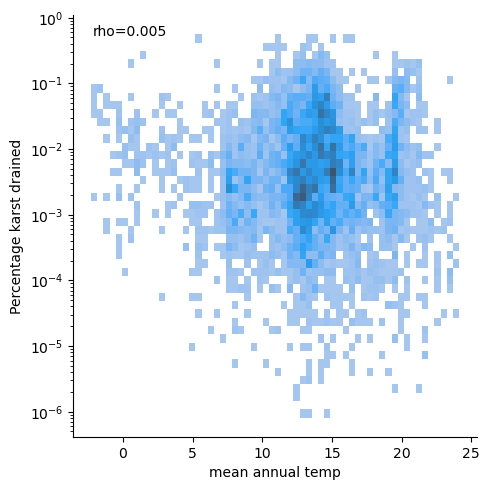

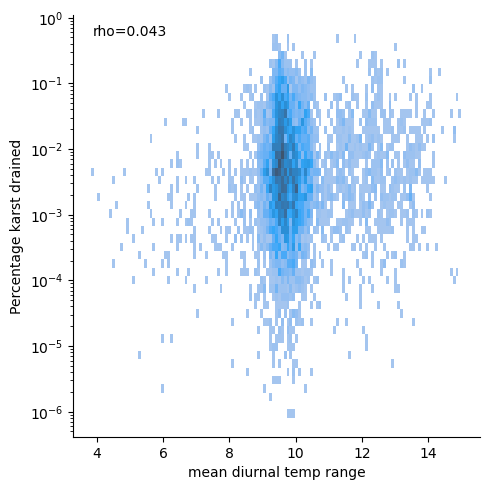

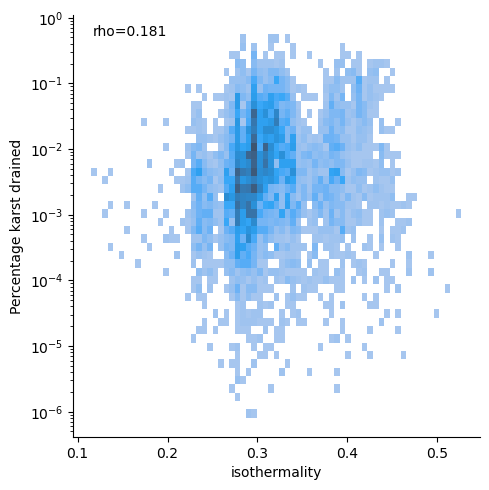

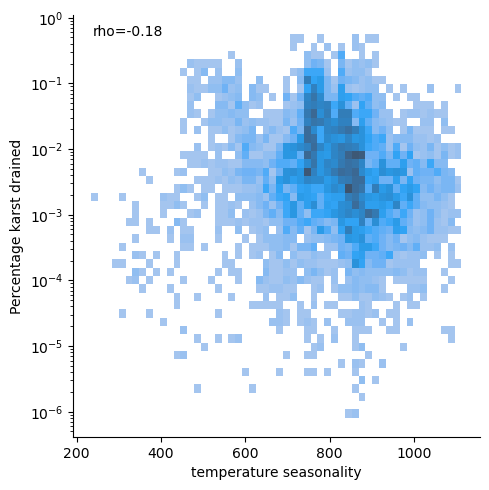

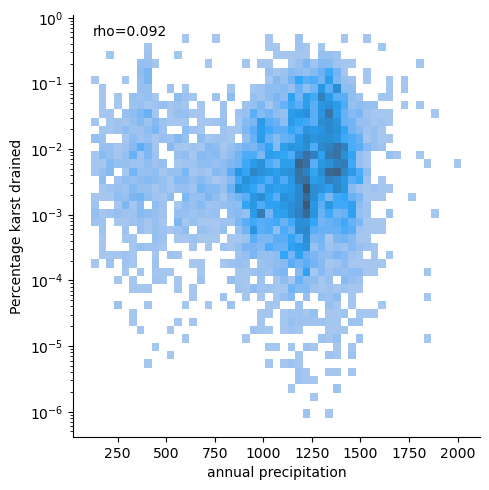

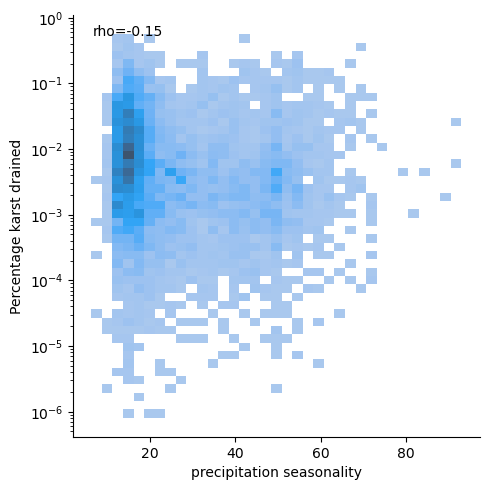

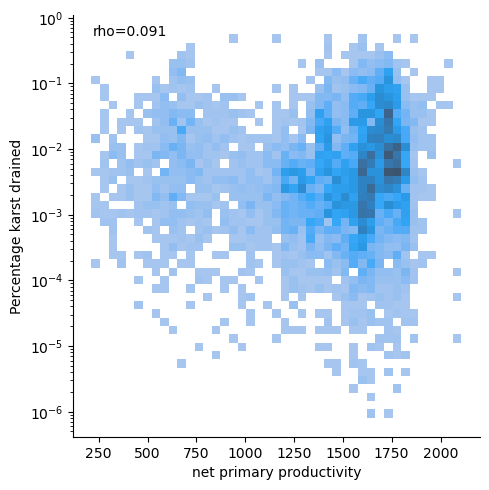

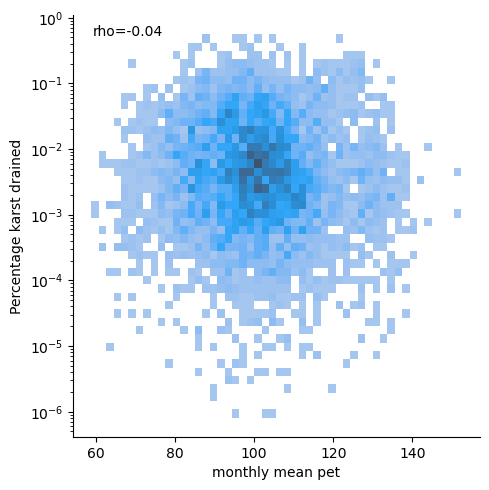

In [63]:
for param in raster_key.index:
     make_displot(param, 
             p_karst, 
             controls_df,              
        )

<AxesSubplot: >

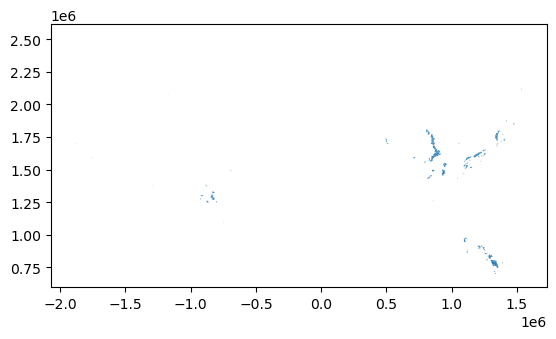

In [64]:
high_p_karst = p_karst_df[p_karst>0.1]
high_p_karst.plot()